<h2 id='part1'>Project 1: Blog</h2>
Looking into the population of the stack Overflow data, I wanted to look at the difference in the population between men and women.

__The questions that I want to answer are:__
<br> a) How does pay differ between men and women?
<br> b) What are the drivers for the differences in pay?
<br> c) From the data, are there strong personal p we use it to predict salary?
 
 
 
 
 Licence info:
This database - The Public 2018 Stack Overflow Developer Survey Results - is made available under the Open Database License (ODbL): http://opendatacommons.org/licenses/odbl/1.0/. Any rights in individual contents of the database are licensed under the Database Contents License: http://opendatacommons.org/licenses/dbcl/1.0/


In [1]:
#importing pakcages and reading in data from multiple sources

import numpy as np
import pandas as pd
from copy import deepcopy

import os
#from statistics import mean

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

file_path = os.path.join(os.getcwd(),r"StackOverflow_Data\2018\survey_results_public.csv")

df=pd.read_csv(file_path)

#Selecting columns used for the analysis  
cols = ['CareerSatisfaction','JobSatisfaction','Respondent',
        'Country','LanguageWorkedWith','Gender','SexualOrientation',
        'EducationParents','RaceEthnicity','Age','ConvertedSalary',
        'UndergradMajor','FormalEducation','YearsCoding','Dependents']


df_personal = df[cols]


C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Question 1: How does pay differ between men and women?

In [2]:
#Output for first Display
def split_and_stack(df_orig, col, sep):
    
    """This splits multiple choice answers within a column into multiple columns, then converts them into extra rows
    so that the popultion can be analysed.
    
    Steps:
    1) Splits a single column in a dataframe into multiple columns (/levels), using a defined seperator.
    2) Stacks these extra column entries into rows, but shows indexes of extra levels which the data was split over.
    3) Extra levels / generated columns are then dropped.
    4) Renames the last column as the Orignal column name.
    
    Parameters:
    df_orig (pandas.DataFrame): A DataFrame containing columns with multiple choice answers.
    col (string): The column which requires multiple choice answers to be split.
    sep (string): The seperator which the column (col) mentioned above needs to be split over.

    Returns:
    pandas.DataFrame:Returning a DataFrame of the total population with extra rows (multiple for the same index) 
    for multiple choice responses.
    
    """
    new_df = df_orig[col].str.split(sep,expand=True).stack().to_frame().reset_index()
    new_df = new_df.drop(['level_0','level_1'], axis=1)
    new_df.columns = [col]
    
    return new_df



df_gender = split_and_stack(df_personal, 'Gender', ';')

#Grouping by and calculating Gender breakdowns. Groupby deals with null values so these are removed.
gender = df_gender.groupby('Gender')['Gender'].count().sort_values(ascending=False)/len(df_gender)
gender_stats = zip(list(gender.index),list(gender))

#Printing stats in percentage form
for gender in gender_stats:
    print(gender[0] + ": " +"{:.2%}".format(gender[1]))
    


Male: 91.68%
Female: 6.76%
Non-binary, genderqueer, or gender non-conforming: 0.91%
Transgender: 0.65%


C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


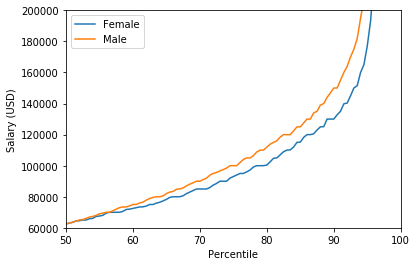

In [3]:
#Output for second display
#Splitting data to male only and female only. Null values for Gender are would be marked false, therefore they are ignored.
df_male = df_personal.dropna()[df_personal.Gender.dropna(axis=0).\
                               apply(lambda x: True if 'Male' in x else False)]

df_female = df_personal.dropna()[df_personal.Gender.dropna(axis=0).\
                                 apply(lambda x: True if 'Female' in x else False)]


#Finding percentiles of salary for male and female. Quantile function ignores nulll values for ConvertedSalary
female_points = [ (i*100, df_female.ConvertedSalary.quantile(i)) for i in np.arange(0,1,0.005) ]
male_points = [ (i*100, df_male.ConvertedSalary.quantile(i)) for i in np.arange(0,1,0.005) ]

x_female = [x[0] for x in female_points]
y_female = [y[1] for y in female_points]

x_male = [x[0] for x in male_points]
y_male = [y[1] for y in male_points]


#setting graph limits x and y limits and labelling axis
plt.ylim((60000,200000))
plt.ylabel('Salary (USD)')
plt.xlabel('Percentile')
plt.xlim((50,100))

plt.plot(x_female, y_female, label = 'Female')
plt.plot(x_male, y_male, label = 'Male')
plt.legend(loc='upper left', prop={'size':10})

#Saving file
plt.savefig(os.path.join(os.getcwd(),'Pay_gap.png'),bbox_inches='tight')

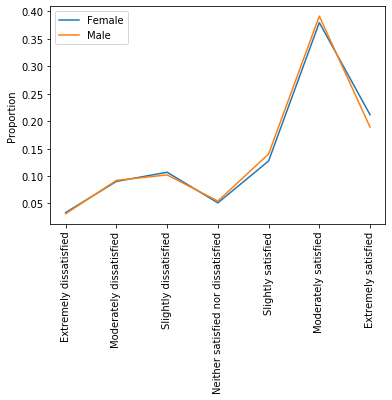

In [4]:
#Output for third display
#Re-casting the CareerSatisfaction to Ordered Category to correctly display in output
df_male['JobSatisfaction']=df_male['JobSatisfaction']\
                                    .astype(pd.api.types.CategoricalDtype(
                                            categories=['Extremely dissatisfied','Moderately dissatisfied',
                                                        'Slightly dissatisfied','Neither satisfied nor dissatisfied',
                                                        'Slightly satisfied','Moderately satisfied','Extremely satisfied'],
                                            ordered=True))

df_female['JobSatisfaction']=df_female['JobSatisfaction']\
                                    .astype(pd.api.types.CategoricalDtype(
                                            categories=['Extremely dissatisfied','Moderately dissatisfied',
                                                        'Slightly dissatisfied','Neither satisfied nor dissatisfied',
                                                        'Slightly satisfied','Moderately satisfied','Extremely satisfied'],
                                            ordered=True))


#Find percentage breakdown for career satisfaction. Count/Groupby function ignores nulll values for CareerSatisfaction
female_points_2 = df_female.groupby('JobSatisfaction').JobSatisfaction.count().sort_index()/len(df_female)
male_points_2 = df_male.groupby('JobSatisfaction').JobSatisfaction.count().sort_index()/len(df_male)

female_sort = list( zip(female_points_2.index, female_points_2))
male_sort = list( zip(male_points_2.index, male_points_2))

x_female_2 = [x[0] for x in female_sort]
y_female_2 = [y[1]for y in female_sort]
x_male_2 = [x[0] for x in male_sort]
y_male_2 = [y[1]for y in male_sort]

#Formatting and generating a graph
plt.ylabel('Proportion')
plt.xticks(rotation=90)

plt.plot(x_female_2, y_female_2, label = 'Female')
plt.plot(x_male_2, y_male_2, label = 'Male')
plt.legend(loc='upper left', prop={'size':10})

plt.savefig(os.path.join(os.getcwd(),'Gender_job_satisfaction.png'),bbox_inches='tight')

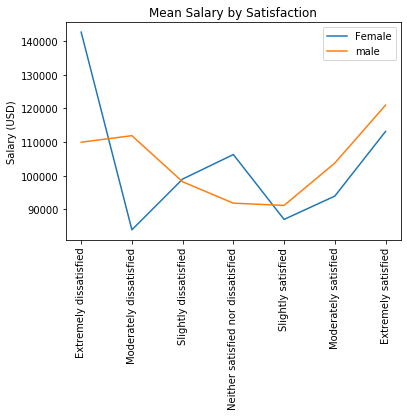

In [96]:
#Find percentage breakdown for career satisfaction. 
#Mean function ignores nulll values for ConvertedSalary. Groupby function ignores nulll values for CareerSatisfaction
female_points_3 = df_female.groupby('JobSatisfaction').ConvertedSalary.mean().sort_index()
male_points_3 = df_male.groupby('JobSatisfaction').ConvertedSalary.mean().sort_index()

female_sort_2 = list(zip(female_points_3.index, female_points_3))
male_sort_2 = list(zip(male_points_3.index, male_points_3))

x_female_3 = [x[0] for x in female_sort_2]
y_female_3 = [y[1] for y in female_sort_2]
x_male_3 = [x[0] for x in male_sort_2]
y_male_3 = [y[1] for y in male_sort_2]

#Formatting and generating a graph
plt.title('Mean Salary by Satisfaction')
plt.ylabel('Salary (USD)')
plt.xticks(rotation=90)

plt.plot(x_female_3, y_female_3, label = 'Female')
plt.plot(x_male_3, y_male_3, label = 'male')

plt.legend(loc='upper right', prop={'size':10})
plt.savefig(os.path.join(os.getcwd(),'Gender_pay_by_Satisfaction.png'),bbox_inches='tight')

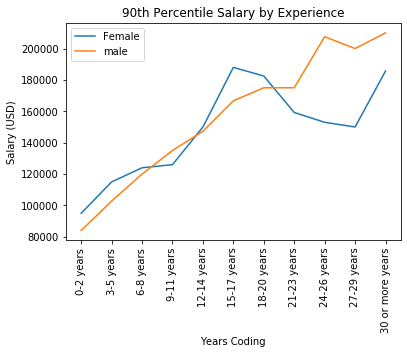

In [6]:
#Calculating 90th percentile salaries by years of experience,  
#Groupby function ignores null values in YearsCoding, quantile function ignores nulll values for ConvertedSalary
female_points_4 = df_female.groupby('YearsCoding').ConvertedSalary.quantile(0.9)
male_points_4 = df_male.groupby('YearsCoding').ConvertedSalary.quantile(0.9)

female_sort_3 = sorted(list(zip(female_points_4.index, female_points_4)),key = lambda x: int(x[0].split()[0].split('-')[0]))
male_sort_3 = sorted(list(zip(male_points_4.index, male_points_4)),key = lambda x: int(x[0].split()[0].split('-')[0]))

x_female_4 = [x[0] for x in female_sort_3]
y_female_4 = [y[1] for y in female_sort_3]
x_male_4 = [x[0] for x in male_sort_3]
y_male_4 = [y[1] for y in male_sort_3]

#Formatting and generating a graph
plt.title('90th Percentile Salary by Experience')
plt.ylabel('Salary (USD)')
plt.xlabel('Years Coding')
plt.xticks(rotation=90)

plt.plot(x_female_4, y_female_4, label = 'Female')
plt.plot(x_male_4, y_male_4, label = 'male')

plt.legend(loc='upper left', prop={'size':10})
plt.savefig(os.path.join(os.getcwd(),'Gender_pay_gap_exp.png'),bbox_inches='tight')


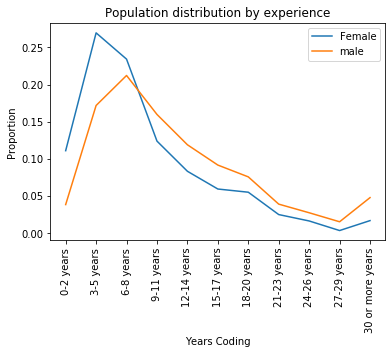

In [7]:
#Calculating population distribution by years of experience. 
#Count function ignores nulll values for ConvertedSalary, Groupby ignores null values in YearsCoding
female_points_5 = df_female.groupby('YearsCoding').YearsCoding.count()/len(df_female)
male_points_5 = df_male.groupby('YearsCoding').YearsCoding.count()/len(df_male)

female_sort_4 = sorted(list(zip(female_points_5.index, female_points_5)),key = lambda x: int(x[0].split()[0].split('-')[0]))
male_sort_4 = sorted(list(zip(male_points_5.index, male_points_5)),key = lambda x: int(x[0].split()[0].split('-')[0]))

x_female_5 = [x[0] for x in female_sort_4]
y_female_5 = [y[1] for y in female_sort_4]
x_male_5 = [x[0] for x in male_sort_4]
y_male_5 = [y[1] for y in male_sort_4]

#Formatting and generating a graph
plt.title('Population distribution by experience')
plt.ylabel('Proportion')
plt.xlabel('Years Coding')
plt.xticks(rotation=90)

plt.plot(x_female_5, y_female_5, label = 'Female')
plt.plot(x_male_5, y_male_5, label = 'male')

plt.legend(loc='upper right', prop={'size':10})
plt.savefig(os.path.join(os.getcwd(),'Gender_exp_pop_dist.png'),bbox_inches='tight')


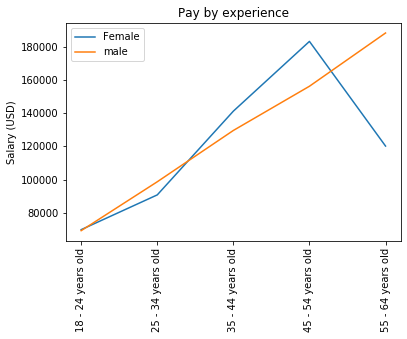

In [108]:
working_professionals = ['18 - 24 years old','25 - 34 years old','35 - 44 years old',
                         '45 - 54 years old','55 - 64 years old']

#Calculating population distribution by years of experience. 
#Count function ignores nulll values for ConvertedSalary, Groupby ignores null values in YearsCoding
female_points_6 = df_female.groupby('Age').ConvertedSalary.mean()[working_professionals]
male_points_6 = df_male.groupby('Age').ConvertedSalary.mean()[working_professionals]

female_sort_5 = list(zip(female_points_6.index, female_points_6))#,key = lambda x: int(x[0].split()[0].split('-')[0]))
male_sort_5 = list(zip(male_points_6.index, male_points_6))#,key = lambda x: int(x[0].split()[0].split('-')[0]))

x_female_5 = [x[0] for x in female_sort_5]
y_female_5 = [y[1] for y in female_sort_5]
x_male_5 = [x[0] for x in male_sort_5]
y_male_5 = [y[1] for y in male_sort_5]

plt.title('Pay by experience')
plt.ylabel('Salary (USD)')
plt.xticks(rotation=90)

plt.plot(x_female_5, y_female_5, label = 'Female')
plt.plot(x_male_5, y_male_5, label = 'male')

plt.legend(loc='upper left', prop={'size':10})
plt.savefig(os.path.join(os.getcwd(),'Pay_by_age.png'),bbox_inches='tight')

<h2 id='part1'>Question 2: Why are there differences in the demographics of men and women?</h2>
    
    

In [94]:
#Looking at population who answered the dependency question and the salary question
df_dep_no_null_f = df_female.dropna(subset=['Dependents','ConvertedSalary'],how='any')
df_dep_no_null_m = df_male.dropna(subset=['Dependents','ConvertedSalary'],how='any')

#Filtering for ages most likley children are to have an impact on salary.
ages_for_children = ['25 - 34 years old','35 - 44 years old','45 - 54 years old']

df_dependents_f=df_dep_no_null_f[df_dep_no_null_f.Age.apply(lambda x: True if x in ages_for_children else False)]
df_dependents_m=df_dep_no_null_m[df_dep_no_null_m.Age.apply(lambda x: True if x in ages_for_children else False)]

#Finding average Salaries by age and by dependents status
female_series = df_dependents_f.groupby(['Dependents','Age']).ConvertedSalary.mean()
male_series = df_dependents_m.groupby(['Dependents','Age']).ConvertedSalary.mean()

#Calculating the relative mean gain/loss
female_dep_cost = female_series['No']/female_series['Yes']
male_dep_cost = male_series['No']/male_series['Yes']


df_dep_cost = pd.concat([pd.DataFrame(list(female_dep_cost), index = list(female_dep_cost.index), columns = ['Female']),
                        pd.DataFrame(list(male_dep_cost), index = list(male_dep_cost.index),columns=['Male'])],axis=1)
df_dep_cost['Female'] = df_dep_cost['Female'].apply(lambda x: "{:.2%}".format(x-1))
df_dep_cost['Male'] = df_dep_cost['Male'].apply(lambda x: "{:.2%}".format(x-1))

df_dep_cost

,Female,Male
25 - 34 years old,7.09%,5.98%
35 - 44 years old,-12.30%,-2.34%
45 - 54 years old,40.75%,5.28%


In [27]:
#Calculating total proportion of Computer Science related degrees for each gender
technical_degree = ['Computer science, computer engineering, or software engineering',
                   'Information systems, information technology, or system administration'
                   'Web development or web design']

#Dropping entries with NaNs for undergrad major, otherwise we would be assuming they were 'Non-Technical'
df_female_grad = df_female.dropna(subset=['UndergradMajor'],axis=0)
df_male_grad = df_male.dropna(subset=['UndergradMajor'],axis=0)

df_female_grad['TechnicalDegree'] = df_female_grad.UndergradMajor\
                                    .apply(lambda x : 'Technical' if x in technical_degree else 'Non-Technical')
df_male_grad['TechnicalDegree'] = df_male_grad.UndergradMajor\
                                    .apply(lambda x : 'Technical' if x in technical_degree else 'Non-Technical')

female_tech_bd = df_female_grad.groupby('TechnicalDegree').TechnicalDegree.count()/len(df_female_grad)
male_tech_bd = df_male_grad.groupby('TechnicalDegree').TechnicalDegree.count()/len(df_male_grad)

print('Women with a Computer Science related degree: ' + "{:.2%}".format(female_tech_bd['Technical']))
print('Men with a Computer Science related degree: ' + "{:.2%}".format(male_tech_bd['Technical']))


Women with a Computer Science related degree: 50.88%
Men with a Computer Science related degree: 63.71%


In [30]:
#Filtering list to only Technical people over 35
df_female_tech = df_female_grad[df_female['TechnicalDegree']=='Technical']
df_male_tech = df_male_grad[df_male['TechnicalDegree']=='Technical']

over_35 = ['35 - 44 years old','45 - 54 years old','55 - 64 years old','65 years or older']

female_tech_bd_age = df_female_tech.groupby('Age')['Age'].count()/len(df_female_tech)
male_tech_bd_age = df_male_tech.groupby('Age')['Age'].count()/len(df_male_tech)

print('Women, 35 and over: ' + "{:.2%}".format(female_tech_bd_age[over_35].sum()))
print('Men, 35 and over: ' + "{:.2%}".format(male_tech_bd_age[over_35].sum()))

Women, 35 and over: 17.15%
Men, 35 and over: 25.19%


In [32]:
#FInding the split of STEM graduates in the population
non_STEM = ['Fine arts or performing arts (ex. graphic design, music, studio art)',
            'A social science (ex. anthropology, psychology, political science)',
            'A humanities discipline (ex. literature, history, philosophy)',
            'A business discipline (ex. accounting, finance, marketing)',
            'I never declared a major']

df_female_grad['STEM'] = df_female_grad.UndergradMajor\
                                    .apply(lambda x : 'Non-STEM' if x in non_STEM else 'STEM')
df_male_grad['STEM'] = df_male_grad.UndergradMajor\
                                    .apply(lambda x : 'Non-STEM' if x in non_STEM else 'STEM')

print("Women in STEM: {:.2%}".format(df_female_grad.groupby('STEM').STEM.count()['STEM']/len(df_female_grad)))
print("Men in STEM: {:.2%}".format(df_male_grad.groupby('STEM').STEM.count()['STEM']/len(df_male_grad)))

Women in STEM: 78.83%
Men in STEM: 91.04%


In [38]:
#Filtering out stem graduates only and looking at distribution of stem graduates by age and gender.
df_female_STEM = df_female_grad[df_female_grad['STEM']=='STEM']
df_male_STEM = df_male_grad[df_male_grad['STEM']=='STEM']

working_professionals = ['18 - 24 years old','25 - 34 years old','35 - 44 years old',
                         '45 - 54 years old','55 - 64 years old']

#Count / Groupby function ignores nulll values for Age.
female_STEM_bd_age = df_female_STEM.groupby('Age')['Age'].count()[working_professionals]/len(df_female_STEM)
male_STEM_bd_age = df_male_STEM.groupby('Age')['Age'].count()[working_professionals]/len(df_male_STEM)

#Combining data together into one DataFrame
df_STEM_bd = pd.concat([pd.DataFrame(list(female_STEM_bd_age), index = list(female_STEM_bd_age.index), columns = ['Female']),
                        pd.DataFrame(list(male_STEM_bd_age), index = list(male_STEM_bd_age.index),columns=['Male'])],axis=1)

#Reformatting data into percentages to 2dp.
df_STEM_bd['Female'] = df_STEM_bd['Female'].apply(lambda x: "{:.2%}".format(x))
df_STEM_bd['Male'] = df_STEM_bd['Male'].apply(lambda x: "{:.2%}".format(x))
df_STEM_bd

,Female,Male
18 - 24 years old,21.29%,16.71%
25 - 34 years old,59.23%,56.30%
35 - 44 years old,15.31%,20.42%
45 - 54 years old,3.15%,5.15%
55 - 64 years old,0.97%,1.26%


In [95]:
#Calculating the STEM percentage for __EACH__ age group, by gender
STEM_count_f = df_female_grad.groupby(['STEM','Age']).STEM.count()['STEM'][working_professionals]
STEM_count_f_total = df_female_grad.groupby('Age').STEM.count()[working_professionals]

STEM_count_m = df_male_grad.groupby(['STEM','Age']).STEM.count()['STEM'][working_professionals]
STEM_count_m_total = df_male_grad.groupby('Age').STEM.count()[working_professionals]

STEM_bd_female = STEM_count_f/STEM_count_f_total
STEM_bd_male = STEM_count_m/STEM_count_m_total


#Combining data together into one DataFrame
df_STEM_bd_2 = pd.concat([pd.DataFrame(list(STEM_bd_female), index = list(STEM_bd_female.index), columns = ['Female']),
                        pd.DataFrame(list(STEM_bd_male), index = list(STEM_bd_male.index),columns=['Male'])],axis=1)

#Reformatting data into percentages to 2dp.
df_STEM_bd_2['Female'] = df_STEM_bd_2['Female'].apply(lambda x: "{:.2%}".format(x))
df_STEM_bd_2['Male'] = df_STEM_bd_2['Male'].apply(lambda x: "{:.2%}".format(x))
df_STEM_bd_2

,Female,Male
18 - 24 years old,90.96%,96.25%
25 - 34 years old,76.66%,91.40%
35 - 44 years old,76.44%,87.96%
45 - 54 years old,67.53%,85.38%
55 - 64 years old,66.67%,86.42%


In [93]:
#Looking at population who answered the dependency question and the salary question
df_dep_no_null_f = df_female.dropna(subset=['Dependents','ConvertedSalary'],how='any')
df_dep_no_null_m = df_male.dropna(subset=['Dependents','ConvertedSalary'],how='any')

#Filtering for ages most likley children are to have an impact on salary.
ages_for_children = ['25 - 34 years old','35 - 44 years old','45 - 54 years old']

df_dependents_f=df_dep_no_null_f[df_dep_no_null_f.Age.apply(lambda x: True if x in ages_for_children else False)]
df_dependents_m=df_dep_no_null_m[df_dep_no_null_m.Age.apply(lambda x: True if x in ages_for_children else False)]

#Finding average Salaries by age and by dependents status
female_series = df_dependents_f.groupby(['Dependents','Age']).ConvertedSalary.mean()
male_series = df_dependents_m.groupby(['Dependents','Age']).ConvertedSalary.mean()

#Calculating the relative mean gain/loss
female_dep_cost = female_series['No']/female_series['Yes']
male_dep_cost = male_series['No']/male_series['Yes']


df_dep_cost = pd.concat([pd.DataFrame(list(female_dep_cost), index = list(female_dep_cost.index), columns = ['Female']),
                        pd.DataFrame(list(male_dep_cost), index = list(male_dep_cost.index),columns=['Male'])],axis=1)
df_dep_cost['Female'] = df_dep_cost['Female'].apply(lambda x: "{:.2%}".format(x-1))
df_dep_cost['Male'] = df_dep_cost['Male'].apply(lambda x: "{:.2%}".format(x-1))

df_dep_cost

,Female,Male
25 - 34 years old,7.09%,5.98%
35 - 44 years old,-12.30%,-2.34%
45 - 54 years old,40.75%,5.28%


In [120]:
df_personal.dropna(subset=['Gender'])[df_personal.Gender.dropna().apply(lambda x: True if 'Female' in x else False)]\
            [['EducationParents','FormalEducation']].groupby(['EducationParents','FormalEducation']).size().reset_index()\
            .rename({0:'Count'}, axis = 1).sort_values('Count',ascending =False)


,EducationParents,FormalEducation,Count
7,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Bachelor’s degree (BA, BS, B.Eng., etc.)",796
16,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Bachelor’s degree (BA, BS, B.Eng., etc.)",428
18,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Master’s degree (MA, MS, M.Eng., MBA, etc.)",366
52,"Secondary school (e.g. American high school, G...","Bachelor’s degree (BA, BS, B.Eng., etc.)",269
9,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Master’s degree (MA, MS, M.Eng., MBA, etc.)",256
61,Some college/university study without earning ...,"Bachelor’s degree (BA, BS, B.Eng., etc.)",175
25,"Other doctoral degree (Ph.D, Ed.D., etc.)","Bachelor’s degree (BA, BS, B.Eng., etc.)",132
54,"Secondary school (e.g. American high school, G...","Master’s degree (MA, MS, M.Eng., MBA, etc.)",112
1,Associate degree,"Bachelor’s degree (BA, BS, B.Eng., etc.)",93
43,"Professional degree (JD, MD, etc.)","Bachelor’s degree (BA, BS, B.Eng., etc.)",93


<h2 id='part1'>Question 3, Are the... ?</h2>
 

In [100]:
n=10

cols_2_test=['YearsCoding','LanguageWorkedWith','Country','EducationParents','FormalEducation','UndergradMajor','ConvertedSalary','Respondent']
seperator = ['LanguageWorkedWith','RaceEthnicity']

df_no_na=df_personal[cols_2_test].dropna()

X=df_no_na.drop(['ConvertedSalary','Respondent'], axis=1)
y=df_no_na['ConvertedSalary']

X['YearsCoding']=X['YearsCoding'].apply(lambda x : mean([float(y) for y in x.split()[0].split('-')]))

for col in X.select_dtypes(include=['object','category']).columns:
    
    if col in seperator:
        df_sep=df_personal['LanguageWorkedWith'].str.split(';',expand=True).stack().to_frame().reset_index()
        df_sep=df_sep.drop(['level_0','level_1'], axis=1)
        df_sep.columns=['LanguageWorkedWith']
        keep = list(df_lww.groupby(col)[col].count().sort_values(ascending=False).nlargest(n).index)
                  
    else:    
        keep = X.groupby(col)[col].count().sort_values(ascending=False).nlargest(n).index
        #X[col]=X[col].apply(lambda x: x if x in keep else 'other')
        
    df_ext = pd.DataFrame()
    for col2 in keep:
        df_ext[col2] = X[col].apply(lambda x: 1 if col2 in x else 0)
    
    X = pd.concat([X.drop([col],axis=1),\
                   df_ext],axis=1,sort=False)
    #mapping={}
    #i=0
    #categories = list(X[col].unique())
    #for cat in categories:
    #    mapping[cat]=i
    #    i=i+1
        
    #X[col]=X[col].apply(lambda x: mapping[x])
    
    #X=pd.concat([X.drop([col],axis=1),\
    #             pd.get_dummies(X[col],prefix=col)],axis=1, sort=False)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [101]:
reg=RandomForestRegressor()
reg.fit(X_train,y_train)

y_pred_test= reg.predict(X_test)
y_pred_train= reg.predict(X_train)

print("Test score: ",r2_score(y_test, y_pred_test))
print("Train score: ",r2_score(y_train, y_pred_train))


C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test score:  -0.2177197761655736
Train score:  0.6904464175939575


In [91]:
#list(df.columns)
#df_personal.groupby('LanguageWorkedWith')['LanguageWorkedWith'].count().sort_values(ascending=False)/len(df_personal)
df_lww=df_personal['LanguageWorkedWith'].str.split(';',expand=True).stack().to_frame().reset_index()
df_lww=df_lww.drop(['level_0','level_1'], axis=1)
df_lww.columns=['LanguageWorkedWith']
list(df_lww.groupby('LanguageWorkedWith')['LanguageWorkedWith'].count().sort_values(ascending=False).nlargest(5).index)

['JavaScript', 'HTML', 'CSS', 'SQL', 'Java']

In [ ]:
def df_to_index(df, ignore = []):
    
    """Converts all 'object' or 'category' datatype columns in a DataFrame to an integer datatype column by finding the unique entries 
    and assigning an index to each one, creating a new dataframe.
    
    Note: This requires a CLEAN dataset, i.e no null values
    
    Parameters:
    df (pandas.DataFrame): A DataFrame containing the columns you wish to index.
    ignore (List of strings): The columns which you would like to ignore when indexing.

    Returns:
    pandas.DataFrame: Returning a new DataFrame with indexed versions of the original columns.
    
    """
    list(df.dtypes) + ignore
    cols_to_index = list(df.select_dtypes(include=['object','category']).columns)
    
    for col in cols_to_index:
        if col not in ignore:
            new_df = df

            unique_entries = list(new_df[col].unique())

            new_df[col] = new_df[col].apply(lambda x: unique_entries.index(x))
    
    return new_df


df_clean = df_to_index(df_personal.dropna())


In [128]:
list(df.columns)

['Respondent',
 'Hobby',
 'OpenSource',
 'Country',
 'Student',
 'Employment',
 'FormalEducation',
 'UndergradMajor',
 'CompanySize',
 'DevType',
 'YearsCoding',
 'YearsCodingProf',
 'JobSatisfaction',
 'CareerSatisfaction',
 'HopeFiveYears',
 'JobSearchStatus',
 'LastNewJob',
 'AssessJob1',
 'AssessJob2',
 'AssessJob3',
 'AssessJob4',
 'AssessJob5',
 'AssessJob6',
 'AssessJob7',
 'AssessJob8',
 'AssessJob9',
 'AssessJob10',
 'AssessBenefits1',
 'AssessBenefits2',
 'AssessBenefits3',
 'AssessBenefits4',
 'AssessBenefits5',
 'AssessBenefits6',
 'AssessBenefits7',
 'AssessBenefits8',
 'AssessBenefits9',
 'AssessBenefits10',
 'AssessBenefits11',
 'JobContactPriorities1',
 'JobContactPriorities2',
 'JobContactPriorities3',
 'JobContactPriorities4',
 'JobContactPriorities5',
 'JobEmailPriorities1',
 'JobEmailPriorities2',
 'JobEmailPriorities3',
 'JobEmailPriorities4',
 'JobEmailPriorities5',
 'JobEmailPriorities6',
 'JobEmailPriorities7',
 'UpdateCV',
 'Currency',
 'Salary',
 'SalaryType',